In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import math
import statsmodels.api as sm
from scipy import stats
from scipy.stats import skew, kurtosis
from scipy.optimize import minimize
from sklearn import linear_model

## 1. Data Preprocessing

In [2]:
NUM_ASSETS = 27
RISK_FREE_RATE = 0.001
RISK_AVERSION = 10

In [3]:
file = "djreturns.xlsx"
dj27_df = pd.read_excel(file, sheet_name='dj27')
returns_df = pd.read_excel(file, sheet_name='returns')
sp500_df = pd.read_excel(file, sheet_name='sp500')

In [4]:
dj27_df

,PERMNO,COMNAM,TICKER
0,10107,MICROSOFT CORP,MSFT
1,10145,HONEYWELL INTERNATIONAL INC,HON
2,11308,COCA COLA CO,KO
3,12490,INTERNATIONAL BUSINESS MACHS COR,IBM
4,14008,AMGEN INC,AMGN
5,14541,CHEVRON CORP,CHV
6,14593,APPLE COMPUTER INC,AAPL
7,18163,PROCTER & GAMBLE CO,PG
8,18542,CATERPILLAR INC,CAT
9,19502,WALGREEN CO,WAG


In [5]:
returns_df

,PERMNO,DATE,COMNAM,TICKER,PRC,RET,SHROUT
0,10107,2000-01-31,MICROSOFT CORP,MSFT,97.875000,-0.161670,5160025
1,10107,2000-02-29,MICROSOFT CORP,MSFT,89.375000,-0.086845,5160025
2,10107,2000-03-31,MICROSOFT CORP,MSFT,106.250000,0.188811,5242000
3,10107,2000-04-28,MICROSOFT CORP,MSFT,69.750000,-0.343529,5262405
4,10107,2000-05-31,MICROSOFT CORP,MSFT,62.562500,-0.103047,5262405
...,...,...,...,...,...,...,...
7123,92655,2021-08-31,UNITEDHEALTH GROUP INC,UNH,416.269989,0.009825,942917
7124,92655,2021-09-30,UNITEDHEALTH GROUP INC,UNH,390.739990,-0.057847,942917
7125,92655,2021-10-29,UNITEDHEALTH GROUP INC,UNH,460.470001,0.178456,942917
7126,92655,2021-11-30,UNITEDHEALTH GROUP INC,UNH,444.220001,-0.035290,941851


In [6]:
sp500_df

,DATE,SPRTRN
0,2000-01-31,-0.050904
1,2000-02-29,-0.020108
2,2000-03-31,0.096720
3,2000-04-28,-0.030796
4,2000-05-31,-0.021915
...,...,...
259,2021-08-31,0.028990
260,2021-09-30,-0.047569
261,2021-10-29,0.069144
262,2021-11-30,-0.008334


## 2. Basic Statistics

In [7]:
def get_basic_statistics(df, return_col):
    # 1) Monthly statistics
    monthly_mean = df[return_col].mean()  # Average return per month (arithmetic mean)
    monthly_std  = df[return_col].std()  # Monthly volatility (sample standard deviation)
    
    # 2) Annualized statistics
    annualized_mean = monthly_mean * 12  # Annualized arithmetic mean return
    annualized_std  = monthly_std * (12 ** 0.5)  # Annualized volatility

    # 3) Shape statistics
    skewness_val = skew(df[return_col], bias=False)  # Sample skewness
    kurtosis_val = kurtosis(df[return_col], bias=False)  # Sample kurtosis

    return pd.Series({
        'Monthly Mean': monthly_mean,
        'Monthly Std Dev': monthly_std,
        'Annualized Mean': annualized_mean,
        'Annualized Std Dev': annualized_std,
        'Skewness': skewness_val,
        'Kurtosis': kurtosis_val
    })

In [8]:
dj27_basic_statistics = (
    returns_df
    .groupby('PERMNO')
    .apply(lambda x: get_basic_statistics(x, 'RET'))
    .reset_index()
    .loc[:, ['PERMNO','Monthly Mean', 'Monthly Std Dev', 'Annualized Mean', 'Annualized Std Dev', 'Skewness', 'Kurtosis']]
)
dj27_basic_statistics = dj27_df.merge(dj27_basic_statistics, on='PERMNO', how='left')
dj27_basic_statistics.to_excel('Basic Statistics1.xlsx')
dj27_basic_statistics

,PERMNO,COMNAM,TICKER,Monthly Mean,Monthly Std Dev,Annualized Mean,Annualized Std Dev,Skewness,Kurtosis
0,10107,MICROSOFT CORP,MSFT,0.011763,0.082184,0.141157,0.284694,0.217214,3.410101
1,10145,HONEYWELL INTERNATIONAL INC,HON,0.010460,0.082777,0.125522,0.286748,-0.132899,7.964764
2,11308,COCA COLA CO,KO,0.006274,0.050813,0.075283,0.176022,-0.504241,1.223350
3,12490,INTERNATIONAL BUSINESS MACHS COR,IBM,0.005450,0.072231,0.065405,0.250215,0.414492,3.647547
4,14008,AMGEN INC,AMGN,0.008606,0.073393,0.103270,0.254240,0.524538,1.860082
5,14541,CHEVRON CORP,CHV,0.008954,0.065371,0.107444,0.226451,0.409425,2.336639
6,14593,APPLE COMPUTER INC,AAPL,0.027702,0.114290,0.332421,0.395911,-0.636435,3.526810
7,18163,PROCTER & GAMBLE CO,PG,0.007764,0.051096,0.093172,0.177001,-1.514530,9.368231
8,18542,CATERPILLAR INC,CAT,0.014445,0.088596,0.173336,0.306904,-0.067620,2.013326
9,19502,WALGREEN CO,WAG,0.006430,0.075547,0.077165,0.261702,0.354493,0.724653


In [9]:
sp500_basic_statistics = pd.DataFrame([get_basic_statistics(sp500_df, 'SPRTRN')], index=['S&P 500']).reset_index()
sp500_basic_statistics.columns = ['Ticker', 'Monthly Mean', 'Monthly Std Dev', 'Annulized Mean', 'Annulized Std Dev', 'Skewness', 'Kurtosis']
sp500_basic_statistics.to_excel('Basic Statistics2.xlsx')
sp500_basic_statistics

,Ticker,Monthly Mean,Monthly Std Dev,Annulized Mean,Annulized Std Dev,Skewness,Kurtosis
0,S&P 500,0.005418,0.043404,0.065021,0.150357,-0.534266,1.128675


- The skewness of -0.531 suggests a slightly left-skewed distribution, meaning there's a longer tail on the left side of the distribution.
- The kurtosis of 1.085 is less than 3, indicating a distribution with lighter tails than a normal distribution.
- These statistics suggest that the S&P 500 return distribution for the period 2000–2021 is not perfectly normal, exhibiting a slight left skewness and a platykurtic shape (flatter peak and lighter tails than a normal distribution). 

## 3. Indexing

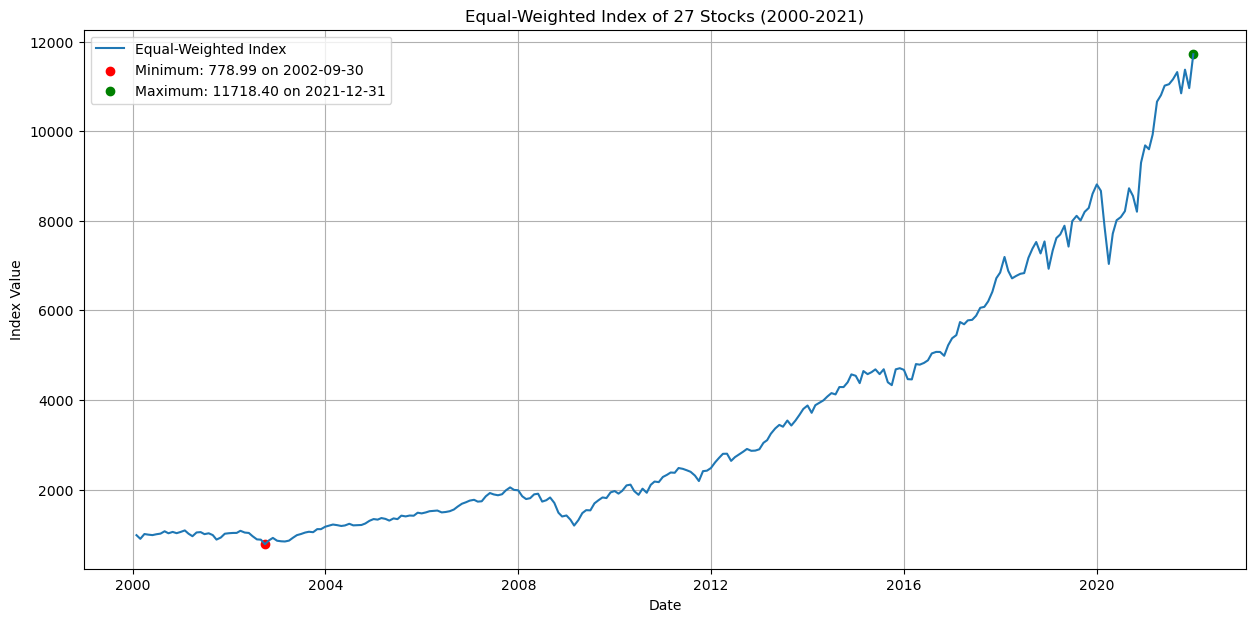

Minimum Point: Date: 2002-09-30, Value: 778.991112
Maximum Point: Date: 2021-12-31, Value: 11718.396301


<Figure size 640x480 with 0 Axes>

In [10]:
monthly_index_returns = returns_df.groupby('DATE')['RET'].mean()

index_start_value = 1000
index_values = (1 + monthly_index_returns).cumprod() * index_start_value

index_min_date, index_min_value = index_values.idxmin(), index_values.min()
index_max_date, index_max_value = index_values.idxmax(), index_values.max()

index_min_date_formatted = index_min_date.strftime('%Y-%m-%d')
index_max_date_formatted = index_max_date.strftime('%Y-%m-%d')

plt.figure(figsize=(15, 7))
plt.plot(index_values, label='Equal-Weighted Index')
plt.scatter(index_min_date, index_min_value, color='red', label=f'Minimum: {index_min_value:.2f} on {index_min_date_formatted}')
plt.scatter(index_max_date, index_max_value, color='green', label=f'Maximum: {index_max_value:.2f} on {index_max_date_formatted}')
plt.title('Equal-Weighted Index of 27 Stocks (2000-2021)')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('indexing.png')

print(f"Minimum Point: Date: {index_min_date_formatted}, Value: {round(index_min_value, 6)}")
print(f"Maximum Point: Date: {index_max_date_formatted}, Value: {round(index_max_value, 6)}")

## 4. Mean-Variance analysis

In [11]:
# get portfolio volatility by multiplying weights to covariance matrix
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(weights.T @ cov_matrix @ weights)

# get portfolio returns by multiplying weights to mean_returns
def portfolio_return(weights, returns):
    return weights.T @ returns

In [12]:
def minimum_variance(returns, expected_return=None):
    # initial guess
    init_guess = np.ones(NUM_ASSETS) / NUM_ASSETS

    # constraints
    if expected_return is None:
        constraints = [{"type": "eq", "fun": lambda x: np.sum(x) - 1}]
    else:
        constraints = [{"type": "eq", "fun": lambda x: np.sum(x) - 1},
                       {"type": "eq", "fun": lambda x: portfolio_return(x, mean_returns) - expected_return}]

    # bounds
    bounds = [(-10000000000, 100000000000) for i in range(NUM_ASSETS)]
                                    
    # optimization
    result = minimize(fun=portfolio_volatility,
                      x0=init_guess,
                      args=(cov_mat,),
                      method="SLSQP",
                      constraints=constraints,
                      bounds=bounds)

    # return minimum variance portfolio weights, returns, volatilities
    min_var_w = result.x
    min_var_ret = np.sum(returns * min_var_w)
    min_var_vol = result.fun
    
    return min_var_w, min_var_ret, min_var_vol

In [13]:
def maximum_sharpe_ratio(rf_rate, returns, cov_matrix):
    # initial guess
    init_guess = np.ones(NUM_ASSETS) / NUM_ASSETS

    # sharpe ratio
    def negative_sharpe_ratio(weights):
        return - (portfolio_return(weights, returns) - rf_rate) / portfolio_volatility(weights, cov_matrix)
    
    # constraints
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]

    # bounds
    bounds = [(-10000000000, 100000000000) for i in range(NUM_ASSETS)]

    # optimization
    result = minimize(fun=negative_sharpe_ratio, 
                      x0=init_guess, 
                      method='SLSQP', 
                      bounds=bounds, 
                      constraints=constraints)

    # return maximum sharpe ratio portfolio weights, returns, volatilities
    max_sharpe_w = result.x
    max_sharpe_ret = portfolio_return(max_sharpe_w, returns)
    max_sharpe_vol = portfolio_volatility(max_sharpe_w, cov_matrix)

    return max_sharpe_w, max_sharpe_ret, max_sharpe_vol

In [14]:
def maximum_utility_score(coef, returns, cov_matrix):
    # initial guess
    init_guess = np.ones(NUM_ASSETS) / NUM_ASSETS

    # utility score
    def negative_utility_score(weights):
        return - (portfolio_return(weights, returns) - coef * (portfolio_volatility(weights, cov_matrix) ** 2) / 2)
    
    # constraints
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]

    # bounds
    bounds = [(-10000000000, 100000000000) for i in range(NUM_ASSETS)]

    # optimization
    result = minimize(fun=negative_utility_score, 
                      x0=init_guess, 
                      method='SLSQP', 
                      bounds=bounds, 
                      constraints=constraints)

    max_utility_w = result.x
    max_utility_ret = portfolio_return(max_utility_w, returns)
    max_utility_vol = portfolio_volatility(max_utility_w, cov_matrix)

    return max_utility_w, max_utility_ret, max_utility_vol

In [15]:
pivot_returns = returns_df.pivot(index='DATE', columns='PERMNO', values='RET')
asset_data = pd.DataFrame(pivot_returns.mean()).transpose()
mean_returns = asset_data.loc[0]
cov_mat = pivot_returns.cov()

### Efficient Froentier

In [16]:
r_low = mean_returns.min()
r_high = mean_returns.max()
delta_r = (3 * r_high - r_low / 3) / 10
expected_returns = np.arange(r_low / 3, 3 * r_high + delta_r, delta_r)

portfolios = pd.DataFrame(columns=['Weights', 'Mean', 'Standard Deviation'])
index = 0
for r in expected_returns:
    w, ret, std = minimum_variance(mean_returns, r)
    w = w.round(6)
    portfolios.loc[index] = [w, ret, std]
    index += 1
    
portfolios[["Mean", "Standard Deviation"]] = portfolios[["Mean", "Standard Deviation"]].round(6)
portfolios.index = [i+1 for i in range(11)]
portfolios.index.name = 'Index'
portfolios.to_excel('portfolios.xlsx')
portfolios

,Weights,Mean,Standard Deviation
Index,,,
1,"[-0.012522, -0.125453, 0.149354, 0.130678, 0.0...",0.001816,0.036744
2,"[0.036487, -0.093983, 0.068653, 0.029397, 0.03...",0.009945,0.031851
3,"[0.085189, -0.06295, -0.005802, -0.071861, 0.0...",0.018074,0.042676
4,"[0.134744, -0.033244, -0.080125, -0.172942, 0....",0.026203,0.061405
5,"[0.186519, -0.00114, -0.170213, -0.274158, 0.0...",0.034332,0.082834
6,"[0.237482, 0.028192, -0.251862, -0.374125, 0.1...",0.042460,0.105334
7,"[0.285919, 0.057784, -0.333723, -0.475076, 0.1...",0.050589,0.128340
8,"[0.335569, 0.086407, -0.414018, -0.57519, 0.13...",0.058718,0.151625
9,"[0.384469, 0.114791, -0.49415, -0.675307, 0.14...",0.066847,0.175075


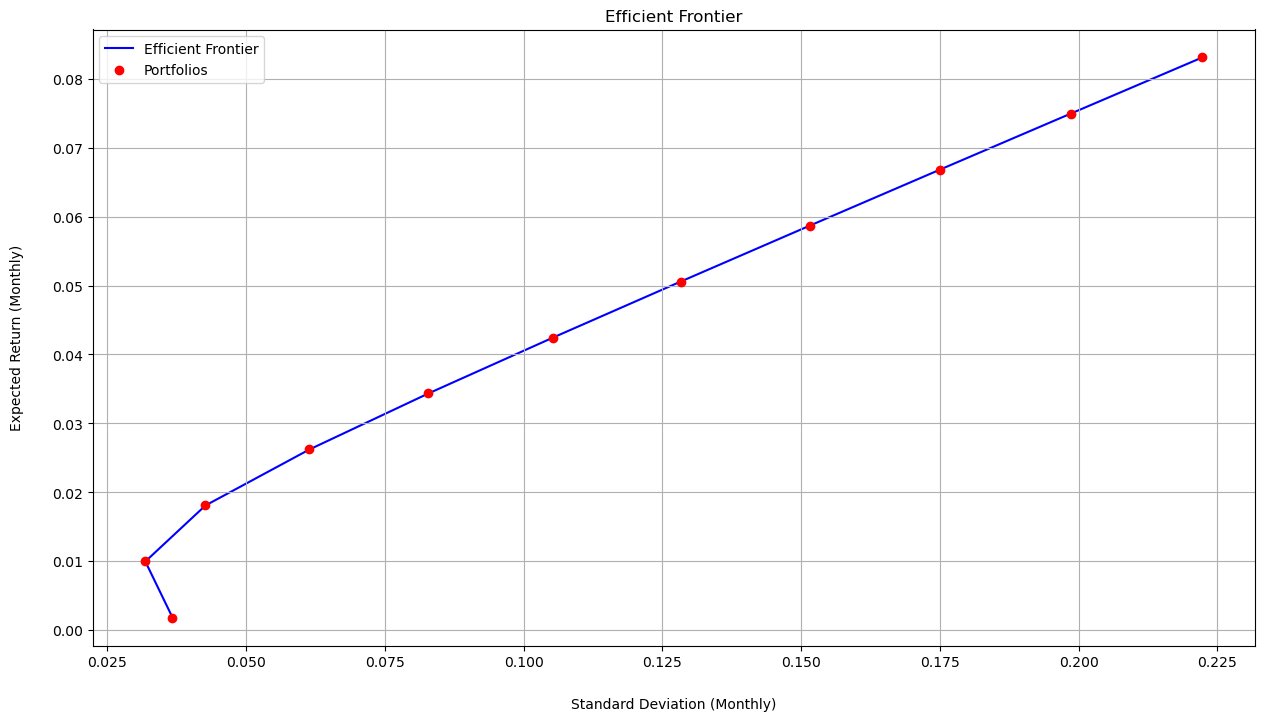

In [17]:
plt.figure(figsize=(15, 8))

# Plotting the efficient frontier
plt.plot(portfolios["Standard Deviation"], portfolios["Mean"], label='Efficient Frontier', color='blue', zorder=1)

# Plotting the portfolios
plt.scatter(portfolios["Standard Deviation"], portfolios["Mean"], label='Portfolios', c='red', zorder=2)

# Titles and labels
plt.title('Efficient Frontier')
plt.xlabel('Standard Deviation (Monthly)', labelpad=20)
plt.ylabel('Expected Return (Monthly)', labelpad=20)
plt.grid(True)
plt.legend()
plt.show()

### Global Minimum Variance Portfolio

In [18]:
min_var_w, min_var_ret, min_var_vol = minimum_variance(mean_returns)
minimum_variance_portfolio = dj27_df.copy()
minimum_variance_portfolio['WEIGHT'] = min_var_w
print(f"The standard deviation of the mininimum variance portfolio is: {round(min_var_vol, 6)}.")
print(f"The return of the mininimum variance portfolio is {round(min_var_ret, 6)}.")
minimum_variance_portfolio.to_excel('minimum_variance_portfolio.xlsx')
minimum_variance_portfolio

The standard deviation of the mininimum variance portfolio is: 0.031467.
The return of the mininimum variance portfolio is 0.008281.


,PERMNO,COMNAM,TICKER,WEIGHT
0,10107,MICROSOFT CORP,MSFT,0.026505
1,10145,HONEYWELL INTERNATIONAL INC,HON,-0.100339
2,11308,COCA COLA CO,KO,0.084797
3,12490,INTERNATIONAL BUSINESS MACHS COR,IBM,0.049923
4,14008,AMGEN INC,AMGN,0.034290
5,14541,CHEVRON CORP,CHV,0.083132
6,14593,APPLE COMPUTER INC,AAPL,0.010222
7,18163,PROCTER & GAMBLE CO,PG,0.266995
8,18542,CATERPILLAR INC,CAT,-0.049237
9,19502,WALGREEN CO,WAG,0.040585


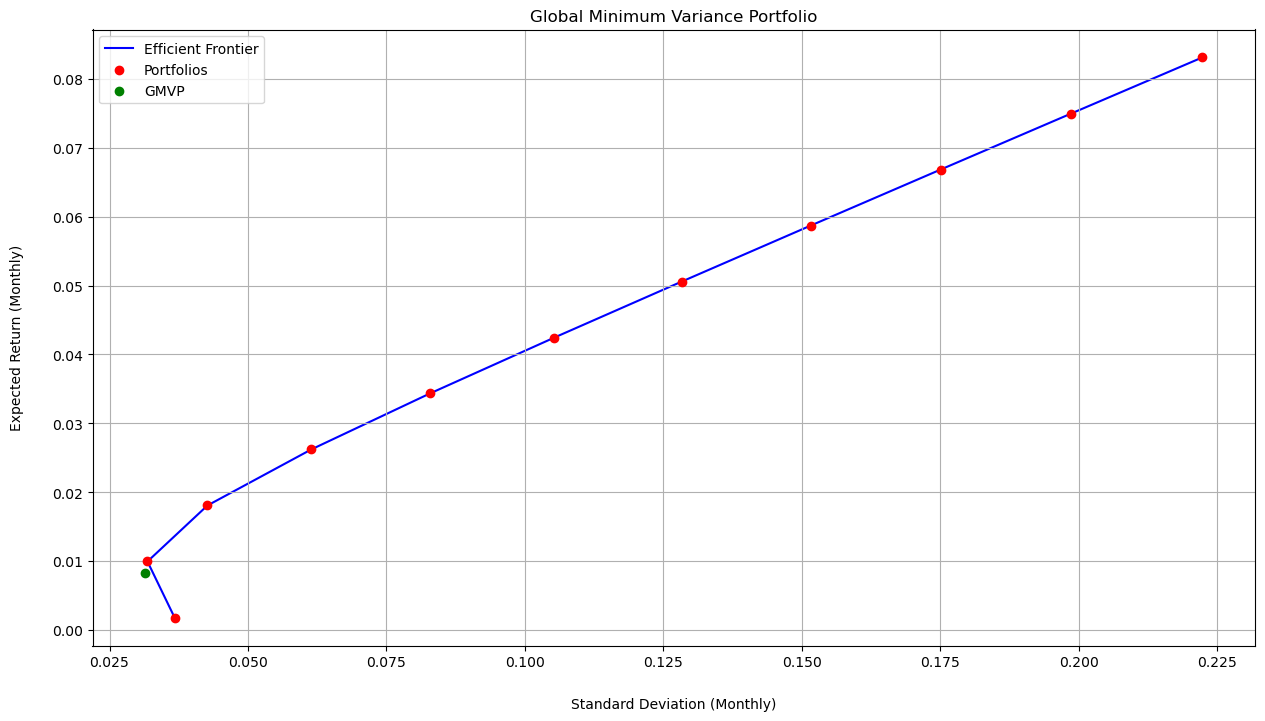

In [19]:
plt.figure(figsize=(15, 8))

# Plotting the efficient frontier
plt.plot(portfolios["Standard Deviation"], portfolios["Mean"], label='Efficient Frontier', color='blue', zorder=1)

# Plotting the portfolios
plt.scatter(portfolios["Standard Deviation"], portfolios["Mean"], label='Portfolios', c='red', zorder=2)

# Plotting the GMVP point
plt.scatter(min_var_vol, min_var_ret, c='green', label='GMVP', zorder=3)

# Titles and labels
plt.title('Global Minimum Variance Portfolio')
plt.xlabel('Standard Deviation (Monthly)', labelpad=20)
plt.ylabel('Expected Return (Monthly)', labelpad=20)
plt.grid(True)
plt.legend()
plt.show()

### Maximum Sharpe Ratio Portfolio (Tangency Portfolio) and Capital Allocation Line (CAL)

In [20]:
max_sharpe_w, max_sharpe_ret, max_sharpe_vol = maximum_sharpe_ratio(RISK_FREE_RATE, mean_returns, cov_mat)
sharp_ratio = (max_sharpe_ret - RISK_FREE_RATE) / max_sharpe_vol
CAL = pd.DataFrame({'Standard Deviation': portfolios["Standard Deviation"]})
CAL['Return'] = RISK_FREE_RATE + sharp_ratio * CAL["Standard Deviation"]
tangency_portfolio = dj27_df.copy()
tangency_portfolio['Weight'] = max_sharpe_w
tangency_portfolio.set_index('PERMNO', inplace=True)
print(f"The average return of the tangency portfolio is {round(max_sharpe_ret, 6)}.")
print(f"The average standard deviation of the tangency portfolio is {round(max_sharpe_vol, 6)}.")
print(f"The sharpe ratio of the tangency portfolio is {round(sharp_ratio, 6)}.")
tangency_portfolio.to_excel('tangency_portfolio.xlsx')
tangency_portfolio

The average return of the tangency portfolio is 0.024011.
The average standard deviation of the tangency portfolio is 0.055965.
The sharpe ratio of the tangency portfolio is 0.41117.


,COMNAM,TICKER,Weight
PERMNO,,,
10107,MICROSOFT CORP,MSFT,0.124611
10145,HONEYWELL INTERNATIONAL INC,HON,-0.038051
11308,COCA COLA CO,KO,-0.069287
12490,INTERNATIONAL BUSINESS MACHS COR,IBM,-0.146705
14008,AMGEN INC,AMGN,0.067417
14541,CHEVRON CORP,CHV,-0.061900
14593,APPLE COMPUTER INC,AAPL,0.306583
18163,PROCTER & GAMBLE CO,PG,0.211871
18542,CATERPILLAR INC,CAT,0.140942


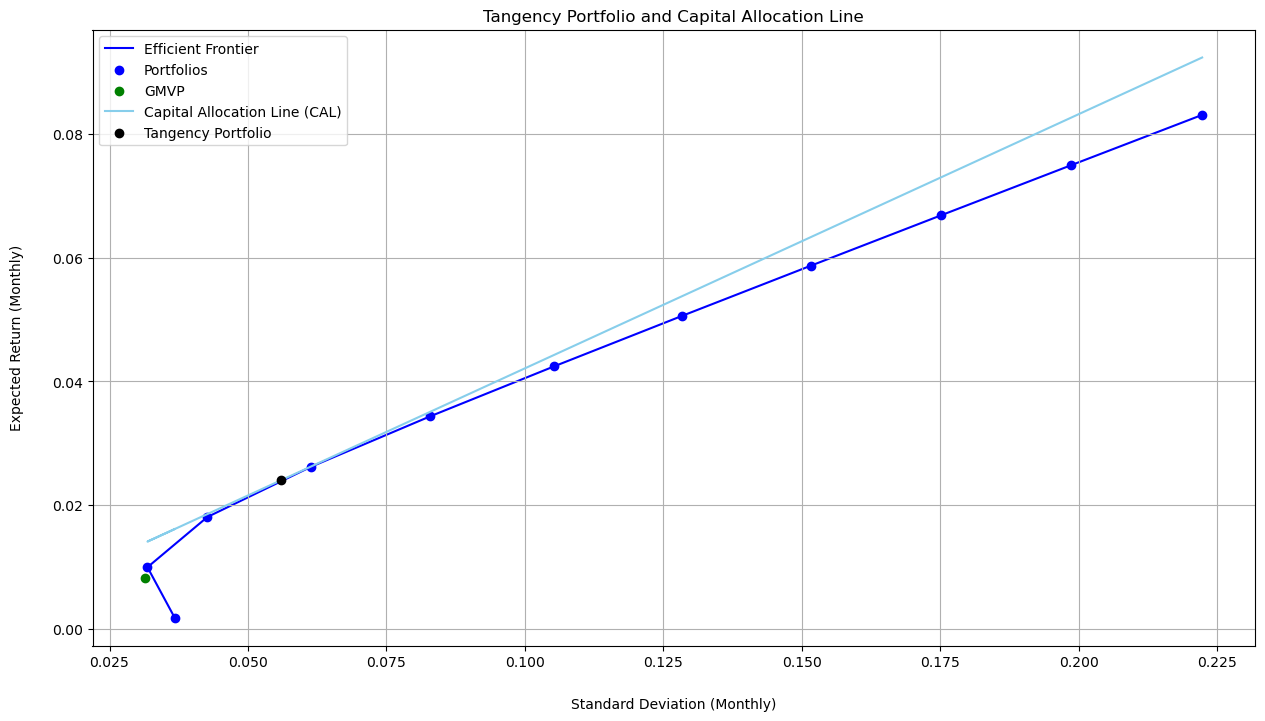

In [21]:
plt.figure(figsize=(15, 8))

# Plotting the efficient frontier
plt.plot(portfolios["Standard Deviation"], portfolios["Mean"], label='Efficient Frontier', color='blue', zorder=1)

# Plotting the portfolios
plt.scatter(portfolios["Standard Deviation"], portfolios["Mean"], label='Portfolios', c='blue', zorder=2)

# Plotting the GMVP point
plt.scatter(min_var_vol, min_var_ret, c='green', label='GMVP', zorder=3)

# Plotting the Capital Allocation Line
plt.plot(CAL["Standard Deviation"], CAL["Return"], label='Capital Allocation Line (CAL)', c='skyblue', zorder=4)

# Highlighting the Tangency Portfolio
plt.scatter(max_sharpe_vol, max_sharpe_ret, label='Tangency Portfolio', c='black', zorder=5)

# Titles and labels
plt.title('Tangency Portfolio and Capital Allocation Line')
plt.xlabel('Standard Deviation (Monthly)', labelpad=20)
plt.ylabel('Expected Return (Monthly)', labelpad=20)
plt.grid(True)
plt.legend()
plt.show()

### Maximum Uitility Portfolio (Optimal Investor Portfolio)

In [22]:
max_utility_w, max_utility_ret, max_utility_vol = maximum_utility_score(RISK_AVERSION, mean_returns, cov_mat)
max_utility = max_utility_ret - (RISK_AVERSION * max_utility_vol ** 2) / 2
utility = dj27_df.copy()
utility['Weight'] = max_utility_w
utility.set_index('PERMNO', inplace=True)
print(f"The average return of the optimal investor holding portfolio is {round(max_utility_ret, 6)}.")
print(f"The average standard deviation of the optimal investor holding portfolio is {round(max_utility_vol, 6)}.")
print(f"The utility of the optimal investor holding portfolio is {round(max_utility, 6)}.")
utility.to_excel('maximum_utility_portfolio.xlsx')
utility

The average return of the optimal investor holding portfolio is 0.019866.
The average standard deviation of the optimal investor holding portfolio is 0.046409.
The utility of the optimal investor holding portfolio is 0.009097.


,COMNAM,TICKER,Weight
PERMNO,,,
10107,MICROSOFT CORP,MSFT,0.103210
10145,HONEYWELL INTERNATIONAL INC,HON,-0.049735
11308,COCA COLA CO,KO,-0.009004
12490,INTERNATIONAL BUSINESS MACHS COR,IBM,-0.097079
14008,AMGEN INC,AMGN,0.064164
14541,CHEVRON CORP,CHV,-0.020537
14593,APPLE COMPUTER INC,AAPL,0.228664
18163,PROCTER & GAMBLE CO,PG,0.212597
18542,CATERPILLAR INC,CAT,0.091024


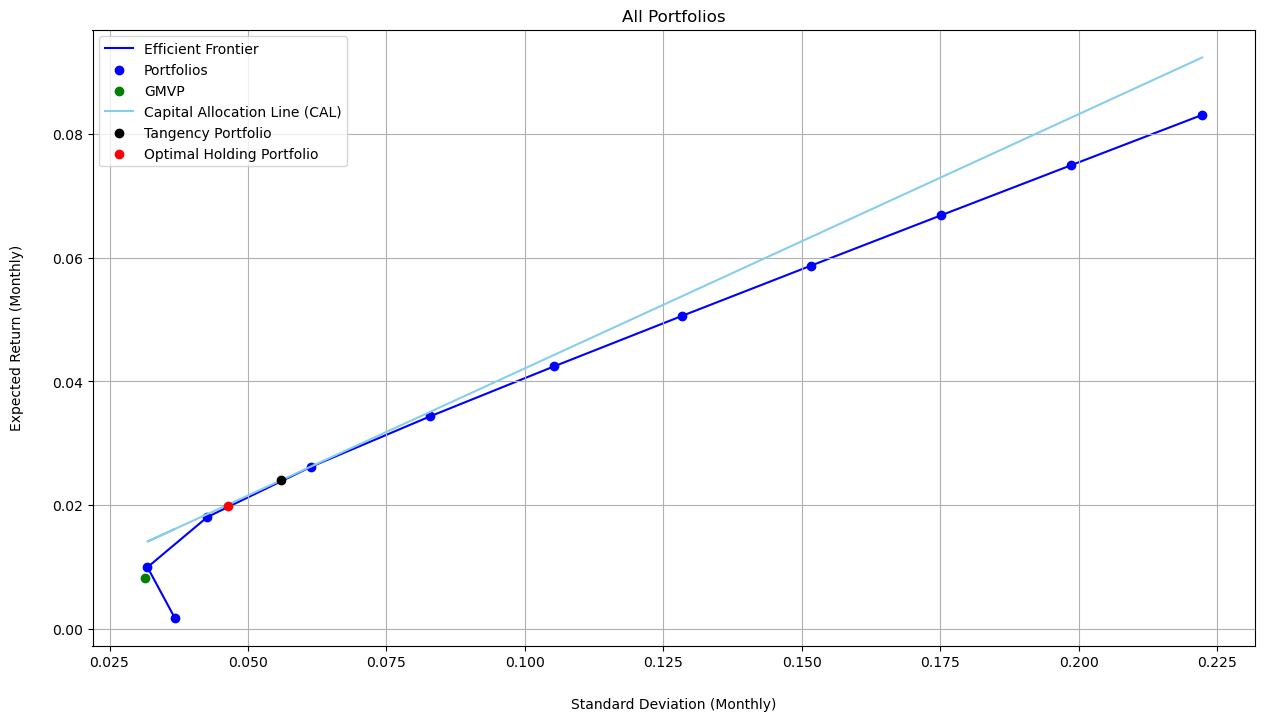

In [23]:
plt.figure(figsize=(15, 8))

# Plotting the efficient frontier
plt.plot(portfolios["Standard Deviation"], portfolios["Mean"], label='Efficient Frontier', color='blue', zorder=1)

# Plotting the portfolios
plt.scatter(portfolios["Standard Deviation"], portfolios["Mean"], label='Portfolios', c='blue', zorder=2)

# Plotting the GMVP point
plt.scatter(min_var_vol, min_var_ret, c='green', label='GMVP', zorder=3)

# Plotting the Capital Allocation Line
plt.plot(CAL["Standard Deviation"], CAL["Return"], label='Capital Allocation Line (CAL)', c='skyblue', zorder=4)

# Plotting the Tangency Portfolio
plt.scatter(max_sharpe_vol, max_sharpe_ret, label='Tangency Portfolio', c='black', zorder=5)

# Plotting the Optimal Holdings Portfolio
plt.scatter(max_utility_vol, max_utility_ret, label='Optimal Holding Portfolio', color='red', zorder=6)

# Titles and labels
plt.title('All Portfolios')
plt.xlabel('Standard Deviation (Monthly)', labelpad=20)
plt.ylabel('Expected Return (Monthly)', labelpad=20)
plt.grid(True)
plt.legend()
plt.show()